# Picture Perfect Fluids

In this notebook we will take an image and turn it into a hydrodynamical simulation. To do this we first need to ingest an image, then convert each pixel into a particle distribution with positions, masses, densities, velocities and internal energies. Finally we will write this out to a SWIFT snapshot file.

Please do upload your own images to try this out with and post results to the workshop Slack channel. To upload your own images, I recommend using `rsync` to transfer them from your local machine to Cosma, e.g. 

```bash
rsync -avz -P /path/to/local/image.png <user>@login8.cosma.dur.ac.uk:/path/to/remote/directory/
```

Note that the image should be a PNG or JPG file, and ideally be square. The simulaiton itself will be square so non-square images will be distorted.

You can find various example notebooks with modified images in this same directory called `example_image_hydro_XXX.ipynb`. These examples show different ways you can modify the particle properties to get different effects.

This whole notebook was adapted from a workshop run by [Josh Borrow at SWIFTCon in 2023](https://github.com/JBorrow/image_to_particles).

## Setting everything up

In the cell below we import the necessary libraries and set up some useful constants.

In [1]:
import sys
import os
from pathlib import Path
import unyt
import PIL
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from swiftsimio import load
from swiftsimio import Writer
from swiftsimio.visualisation import project_gas


# Path to the image 
filepath = Path("images/logo_exgal.png")

# Define the IC filename 
ic_filename = filepath.stem + "_ic.hdf5"

print("Image filepath:", filepath)
print("IC filename:", ic_filename)


Image filepath: images/logo_exgal.png
IC filename: logo_exgal_ic.hdf5


Next we will open the image and resize it, to limit the cost of the simulation since we only have limited resources shared between us. We want to aim for between 128 and 256 pixels on a side. While you could do more you may struggle to get the allocation to run it, so keep this in mind!

In [2]:
# Define the downsampling factor
downsample = 1

# Open the image
image = PIL.Image.open(filepath)

# Get the original size
orig_size = image.size
print("Original image size:", orig_size)

# Downsample the image 
IMAGE_SIZE = (orig_size[0] // downsample, orig_size[1] // downsample)
print("Downsampled image size:", IMAGE_SIZE)

# Resize the image
resized = image.resize((IMAGE_SIZE[0], IMAGE_SIZE[1]))

Original image size: (245, 243)
Downsampled image size: (245, 243)


For simplicities sake we will derive particles from a greyscale version of the image. As you've seen, it's possible to do colour images but this requires a slightly different approach which I leave to you as an extension challenge. 

In the cell below, we convert to greyscale and posterize the image to reduce the number of colours to 256. This helps later when we make particles.

In [3]:
grayscale = PIL.ImageOps.grayscale(resized)
posterized = PIL.ImageOps.posterize(grayscale, 2)

Lets now plot the image just to check it looks OK. If not, by all means go back and adjust the setup or change the image.

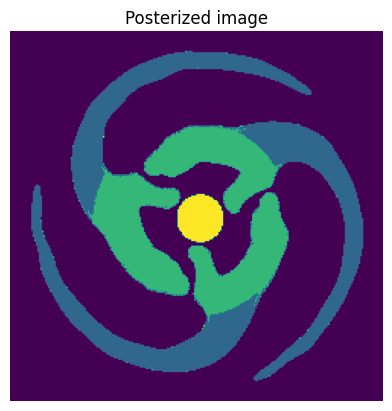

In [4]:
plt.imshow(posterized)
plt.title("Posterized image")
plt.axis("off")
plt.show()
plt.close()

## Pixels to Particles 

Now we need to derive particles from each pixels. We do this by simply sampling each pixel based on the "density" (i.e. brightness) of the pixel.

In [5]:
def particles_from_image(posterized, levels=10):
    """
    Convert a posterized grayscale image into particle coordinates.

    Parameters
    ----------
    posterized : array-like (H, W)
        Image values in [0, 255].
    levels : int
        Number of density levels to use.

    Returns
    -------
    xs, ys, dens : np.ndarray
        Particle coordinates (x, y) and density level per particle.
    """
    # Get the width and height of the image 
    H, W = posterized.size 

    densities = (np.array(posterized).T // levels) + 1
    print(densities.shape)
    xs = []
    ys = []
    dens = []
    for x in np.arange(IMAGE_SIZE[0]):
        for y in np.arange(IMAGE_SIZE[1]):
            density = densities[x, y]

            these_xs, these_ys = np.meshgrid(
                *[(np.arange(density) + 0.5) / float(density)] * 2
            )

            xs.extend(list((these_xs + float(x)).flat))
            ys.extend(list((these_ys + float(y)).flat))
            dens.extend([density] * these_xs.size)

    xs = np.array(xs)
    ys = np.array(ys)
    dens = np.array(dens)
    
    #Scale
    xs= xs / W
    ys= ys / H

    return xs, ys, dens

# Convert the image to particles 
xs, ys, dens = particles_from_image(posterized, levels=50)


(245, 243)


Lets check everything looks OK by plotting the particles.

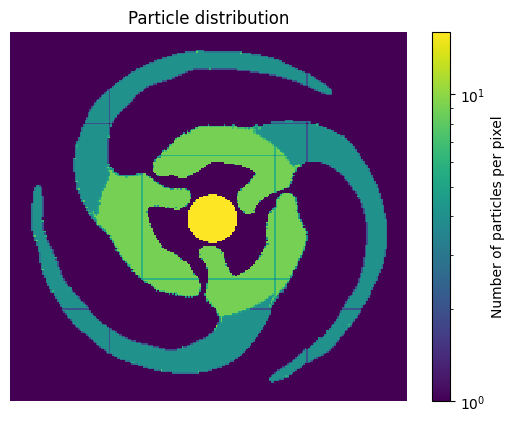

In [6]:
h = plt.hist2d(xs, -ys, norm=LogNorm(), bins=IMAGE_SIZE)
plt.colorbar(h[3], label="Number of particles per pixel")
plt.axis("off")
plt.title("Particle distribution")
plt.show()
plt.close()

Now we have the particles, we just need to create a SWIFT ICs file. To do this we can make use of the [`swiftsimio`](https://swiftsimio.readthedocs.io/en/latest/) library, which has a convenient function to write out a snapshot file.

To do this we will define a lot of the particle properties to be constant, but you can of course modify this to get different effects. For example, you could make the internal energy depend on the pixel brightness, add some random velocity dispersion to the particles, or localise a spike in internal energy to seed an explosion. 

You can see examples of this in the other example notebooks in this directory. However, it is very easy to create a pathological situation which could break or require adjustments to parameters. If you do run into issues, just let us know and we can help. (But dumping 10**100 cm / s^2 of energy into a particle is probably not a good idea!)

Finally we write out the snapshot file.

In [7]:
# Define the unit boxsize
boxsize = (1.0 * unyt.cm, 1.0 * unyt.cm)
print("Boxsize:", boxsize, "Npart:", len(xs))

# Create the IC writer
x = Writer("cgs", boxsize, dimension=2)

# Particle count
n_p = len(xs)

# Make cartesian velocities that rotate the logo around the centre
vels = np.zeros((xs.size, 3))
vr = 0.0 
vtheta = 0.1
xcentre = 0.5
ycentre = 0.5
for i in range(xs.size):
    xrel = xs[i] - xcentre
    yrel = ys[i] - ycentre
    r = np.sqrt(xrel**2 + yrel**2)
    if r > 0:
        vels[i, 0] = vr * (xrel / r) - vtheta * (yrel / r)
        vels[i, 1] = vr * (yrel / r) + vtheta * (xrel / r)

# Attach the coordinates and velocities
x.gas.coordinates = np.array([xs, ys, np.zeros_like(xs)]).T * unyt.cm
x.gas.velocities = vels * (unyt.cm / unyt.s)

# Constant mass for each particle
mass = np.ones(n_p, dtype=float)
x.gas.masses = mass * unyt.g

# Constant small internal energy for each particle
x.gas.internal_energy = np.ones(n_p, dtype=float) * 1e-3 * (unyt.cm / unyt.s) ** 2

# Calculate the smoothing lengths 
x.gas.generate_smoothing_lengths(boxsize=boxsize, dimension=2)

# Write out the ICs 
x.write(ic_filename)

Boxsize: (unyt_quantity(1., 'cm'), unyt_quantity(1., 'cm')) Npart: 158417


If you want to explore what is in the IC file I recommend exploring it on the command line with [`h5forest`](https://github.com/WillJRoper/h5forest). This can be installed with `pip install h5forest` and then you can run `h5forest <filename>` to explore the contents of the file. 

(This definitely isn't shameless self-promotion for a package I wrote to explore HDF5 files...)

## Defining the parameter file

We're nearly there now, just need a parameter file which can be created easily using the function below. This should be fine as is, but you may want to adjust the `time_end` argument depending on how long a video you when you are finished. 

In [ ]:
def create_swift_parameter_file(ic_filename, snap_name='kelvin_helmholtz', visc_alpha=0.8, time_end=1.0):
    """
    Create a SWIFT parameter file for the Kelvin-Helmholtz simulation
    """
    
    # Ensure output directory exists
    os.makedirs('../params', exist_ok=True)
    param_file = f'../params/{snap_name}.yml'

    # Ensure snapshots directory exists
    os.makedirs(f'snapshots/{snap_name}', exist_ok=True)

    param_content = f"""
# Define the system of units to use internally. 
InternalUnitSystem:
  UnitMass_in_cgs:     1   # g 
  UnitLength_in_cgs:   1   # cm
  UnitVelocity_in_cgs: 1   # cm/s  
  UnitCurrent_in_cgs:  1   # amperes
  UnitTemp_in_cgs:     1   # kelvin

# Parameters governing the time integration
TimeIntegration:
  time_begin: 0.0    # The starting time of the simulation (in internal units).
  time_end:   {time_end}   # The end time of the simulation (in internal units).
  dt_min:     1e-6  # The minimal time-step size of the simulation (in internal units).
  dt_max:     1e-2  # The maximal time-step size of the simulation (in internal units).


# Parameters governing the snapshots
Snapshots:
  basename:            snapshots/{snap_name}/{snap_name}  # Common part of the name of output files
  time_first:          0.               # Time of the first output (in internal units)
  delta_time:          0.01      # Time difference between consecutive outputs (in internal units)
  compression:         1              # GZIP compression level (0-9)

# Parameters governing the conserved quantities statistics
Statistics:
  delta_time:          0.01    # Time between statistics output

Scheduler:
  max_top_level_cells: 8

# Parameters for the hydrodynamics scheme
SPH:
  resolution_eta:        1.2348   # Target smoothing length in units of the mean inter-particle separation
  CFL_condition:         0.1      # Courant-Friedrichs-Levy condition for time integration
  viscosity_alpha:       {visc_alpha}     # (Optional) Override for the initial value of the artificial viscosity. In schemes that have a fixed AV, this remains as alpha throughout the run.


# Parameters related to the initial conditions
InitialConditions:
  file_name:  {ic_filename}    # The file to read
  periodic:   1                       # Periodic boundary conditions
"""
    
    with open(param_file, 'w') as f:
        f.write(param_content)
    
    print(f"Created parameter file: {param_file}")
    return param_file

# Create parameter file
param_file = create_swift_parameter_file(ic_filename, snap_name=filepath.stem, time_end=2.0)

## Configuring and compiling SWIFT 

To run the simulation we need to configure and compile SWIFT to run a 2D hydrodynamics simulation. This is done in the cell below (but assumes you have run the setup script that defines the relevant environment variables).

In [ ]:
%%bash
module load intel_comp/2024.2.0 compiler-rt tbb compiler ucx/1.17.0 hdf5 
cd ../swiftsim
./configure \
  --with-hydro=sphenix \
  --with-hydro-dimension=2 \
  --enable-ipo \
  --with-kernel=wendland-C2 \
  --disable-mpi
make -j


## Running SWIFT 

Now we are ready to run SWIFT. This can be done by running a SLURM submission script which we generate below. This is so we can run with a suitable amount of resource without overloading the shared system. You may sit in the queue for a short while but the simulations should run quickly.

In [ ]:
def generate_slurm_script(param_file, job_name='swift-img', time_limit='00:10:00', nthreads=8):
    """
    Generate a SLURM submission script to run SWIFT with the given parameter file.
    """
    
    # Ensure output directory exists
    script_file = "submit"
    
    script_content = f"""#!/bin/bash -l
#SBATCH --ntasks=1
#SBATCH -J {job_name}
#SBATCH --output=log_%j.txt
#SBATCH -p dine2
#SBATCH -A do020
#SBATCH --cpus-per-task={nthreads}
#SBATCH --time={time_limit}

module purge
module load intel_comp/2024.2.0 compiler-rt tbb compiler mpi ucx/1.17.0 parallel_hdf5/1.14.4 fftw/3.3.10 parmetis/4.0.3-64bit gsl/2.8

../swiftsim/swift --hydro --threads=$SLURM_CPUS_PER_TASK {param_file}

echo "Job done, info follows..."
sacct -j $SLURM_JOBID --format=JobID,JobName,Partition,AveRSS,MaxRSS,AveVMSize,MaxVMSize,Elapsed,ExitCode
exit

"""

    with open(script_file, 'w') as f:
        f.write(script_content)

    print(f"SLURM submission script generated: {script_file}")

generate_slurm_script(param_file, job_name=filepath.stem, time_limit='00:10:00', nthreads=8)

Now we just submit the job to the queue and wait.

In [ ]:
%%bash 
sbatch submit

If you want to check on the run you can use the `squeue --m` command to see the status of your jobs. Don't move on to the next cell before your job has finished!

In [ ]:
%%bash
squeue --m

## Visualising the results 

In the cell below we make a video using `swiftsimio` to load the snapshots and `matplotlib` to make a video. You can adjust the `interval` argument to change the speed of the video. 

In [ ]:
import glob
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import matplotlib

matplotlib.use("Agg")

# Make the videos directory if it doesn't exist
os.makedirs('videos', exist_ok=True)


def load_and_extract(filename):
    """
    Load the data and extract relevant info.
    """

    return load(filename)


def make_plot(filename, array, nx, ny, dx, dy):
    """
    Plot this frame. 

    Load the data and plop it on the grid using nearest
    neighbour searching for finding the 'correct' value of
    the density.
    """

    data = load_and_extract(filename)

    mesh = project_gas(data, nx).T.value

    array.set_array(mesh)

    return (array,)


def frame(n, *args):
    """
    Make a single frame. Requires the global variables plot and dpi.
    """

    global plot, dpi

    return make_plot(snapshot_files[n], plot, dpi, dpi, (0, 1), (0, 1))


# Look for snapshot files matching the current run
snapshot_files = sorted(glob.glob(f'snapshots/{filepath.stem}/{filepath.stem}_*.hdf5'))
print(f"Found {len(snapshot_files)} snapshot files.")

# Define the resolution of the output movie
dpi = 512

# Create a progress bar for feedback
frames = tqdm(np.arange(0, len(snapshot_files)), desc="Making frames")

# Set up the plot itself
fig, ax = plt.subplots(1, 1, figsize=(1, 1), frameon=False)
ax.axis("off")  # Remove annoying black frame.

# Load the first frame to get the normalisation
data = load_and_extract(snapshot_files[0])

# Create the first frame
mesh = project_gas(data, dpi).T.value

# Get the normalising percentiles from the first frame 
vmin = np.percentile(mesh, 5)
vmax = np.percentile(mesh, 99)

# Make the plot with the first frame so we can update it during the animation
plot = ax.imshow(
    mesh,
    extent=[0, 1, 0, 1],
    animated=True,
    interpolation="none",
    cmap="viridis",
    norm=LogNorm(vmin=vmin, vmax=vmax, clip=True)
)

# Setup the  animation
anim = FuncAnimation(fig, frame, frames, interval=40, blit=False)

# Remove all whitespace
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

# Actually make the movie
anim.save("videos/" + filepath.stem + ".gif", dpi=dpi)


Once the video has been made, you can download it to your local machine using `rsync` in reverse to how you uploaded the image, e.g.

```bash
rsync -avz -P <user>@login8.cosma.dur.ac.uk:/path/to/movie.gif /path/to/local/directory/
``` 

Please share the videos you've made on the workshop Slack channel!

If you want to play with more "real world" examples, SWIFT comes with a large suite of examples in the `examples/` directory of the SWIFT repository.